In [1]:
"""
texture images mean there are many patterns in the image.
it's hard to work with it without feature extraction
Local Binary Patterns (LBP) don't effect with the illumination and rotation
"""
import os
import zipfile
import urllib.request
import numpy as np
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# open source implementation of LBP
from skimage.feature import local_binary_pattern
# data preprocessing and metrics module in scikit-learn
from sklearn import preprocessing, metrics
# SVM implementation in scikit-learn
from sklearn.svm import LinearSVC

## Download Photos

In [2]:
# download s3_photos.zip
file = 's3_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file
urllib.request.urlretrieve(url, file)

# extract archive and remove zip file
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall('./') # ./ mean the current directory
os.remove(file)

## Local Binary Patterns

In [3]:
def compute_lbp(arr):
    """Find LBP of all pixels.
    Also perform Vectorization/Normalization to get feature vector.
    """
    # LBP function params
    radius = 1
    n_points = 8 * radius
    n_bins = n_points + 2
    lbp = local_binary_pattern(arr, n_points, radius, 'uniform')
    lbp = lbp.ravel() # to make each image as a row vector
    # feature_len = int(lbp.max() + 1)
    feature = np.zeros(n_bins)
    for i in lbp:
        feature[int(i)] += 1
    feature /= np.linalg.norm(feature, ord=1)# to normalized the histogram
    return feature

## Load Data

In [4]:
def load_data(tag='train'):
    """Load (training/test) data from the directory.
    Also do preprocessing of extra features.
    """
    tag_dir = Path.cwd() / tag
    vec = []
    cat = []
    for cat_dir in tag_dir.iterdir(): # iterdir this medthod to get all path in the directory
        cat_label = cat_dir.stem
        for img_path in cat_dir.glob('*.png'):
            img = Image.open(img_path.as_posix())
            if img.mode != 'L': #Luminance / this mean the image not grayscale
                img = ImageOps.grayscale(img)
                img.save(img_path.as_posix()) #The as_posix() method of Path is called to convert the path to a string using the forward slash separator,
            arr = np.array(img)
            feature = compute_lbp(arr)
            vec.append(feature)
            cat.append(cat_label)
    return vec, cat

# train photos
vec_train, cat_train = load_data('train')
# test photos
vec_test, cat_test   = load_data('test')

## List the categories

In [5]:
# get unique categories
labels = list(np.unique(np.array(cat_train)))
labels

[np.str_('Sand'), np.str_('Seed'), np.str_('Stone')]

## Label Encoder

In [6]:
le = preprocessing.LabelEncoder()
label_train = le.fit_transform(cat_train)
label_test = le.transform(cat_test)

## Support Vector Machine fit

In [7]:
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(vec_train, label_train)


LinearSVC(random_state=0, tol=1e-05)

## Evaluation

Accuracy: 100.00%


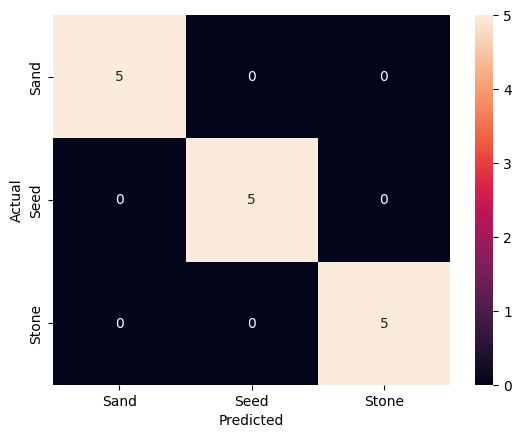

In [8]:

# test set evaluation
prediction = clf.predict(vec_test)
# visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))